In [1]:
import pickle
import numpy as np
from utils.tools_2 import make_library_functions
import matplotlib.pyplot as plt

with open("../data/u_10m_comp_vals_3.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

S_train = loaded_data['train']['data']
train_times = loaded_data['train']['time']

S_test = loaded_data['test']['data']
test_times = loaded_data['test']['time']

S_val = loaded_data['val']['data']
val_times = loaded_data['val']['time']

lat_vals = loaded_data['lat_vals']
lon_vals = loaded_data['lon_vals']

batch_size = max(S_train.shape[1] // 256, 256)

Nh_val = S_train.shape[0]
l_val = 24
r_val = 20
num_features_select = 30


num_epochs = 1000
initial_lr = 1e-2
min_temp = 0.01
start_temp = 10.
library_functions = [ "(_)**2", "(_)**3", "(_)**4", "jnp.sin(_)", "jnp.cos(_)" ]
library_functions = make_library_functions(library_functions)
repulsion_coefficient = 1e-1


# results_dir = f'/workspace/venu_files/climate_forecasting/RL_NLDR_jax_version/results/wCAE_wnl_ne{num_epochs}_lib{len(library_functions)}_bs{batch_size}_lr{initial_lr}_Nval{Nh_val}_lval{l_val}_rval{r_val}_rc{repulsion_coefficient}/'
# results_dir = f'/workspace/venu_files/climate_forecasting/RL_NLDR_jax_version/results/wCAE_wnl_ne{num_epochs}_lib{len(library_functions)}_bs{batch_size}_lr{initial_lr}_Nval{Nh_val}_lval{l_val}_rval{r_val}_rc{repulsion_coefficient}_reconstrerr_fix/'
results_dir = f'/workspace/venu_files/climate_forecasting/RL_NLDR_jax_version/results/wCAE_wnl_ne{num_epochs}_lib{len(library_functions)}_bs{batch_size}_lr{initial_lr}_Nval{Nh_val}_lval{l_val}_rval{r_val}_rc{repulsion_coefficient}_reconstrerr_fix_stg/'


# final_results = {
#     'train_loss_hist': train_loss_history,
#     'val_loss_hist': val_loss_history,
#     'mean_max_prob': mean_max_prob,
#     'logit_vals_hist': logit_vals_hist,
#     'best_train_loss': best_overall_train_loss,
#     'best_val_loss': best_overall_val_loss
#     }

with open(results_dir + "final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

In [2]:
train_loss_history = final_results['train_loss_hist']
val_loss_history = final_results['val_loss_hist']
mean_max_prob = final_results['mean_max_prob']
logit_vals_hist = final_results['logit_vals_hist']
best_overall_train_loss = final_results['best_train_loss']
best_overall_val_loss = final_results['best_val_loss']

0.012934093363583088 : 0.0414721742272377


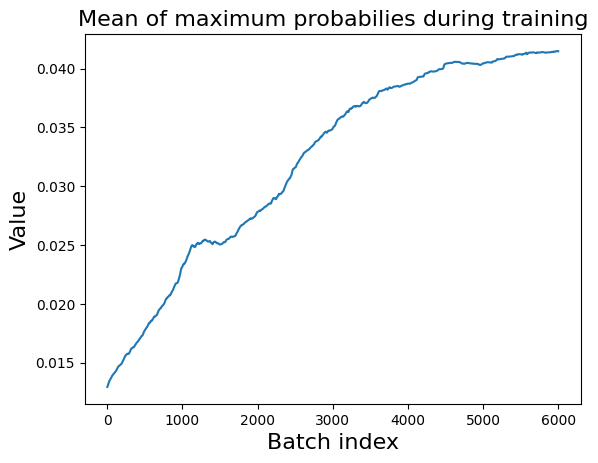

In [3]:
plt.plot(mean_max_prob)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Mean of maximum probabilies during training', fontsize = 16)
plt.savefig(f'{results_dir}mean_max_prob.png')
print(mean_max_prob[0], ":", mean_max_prob[-1])

0.23892250613889832 : 299301610.9758454
0.00039406598 : 974.4553


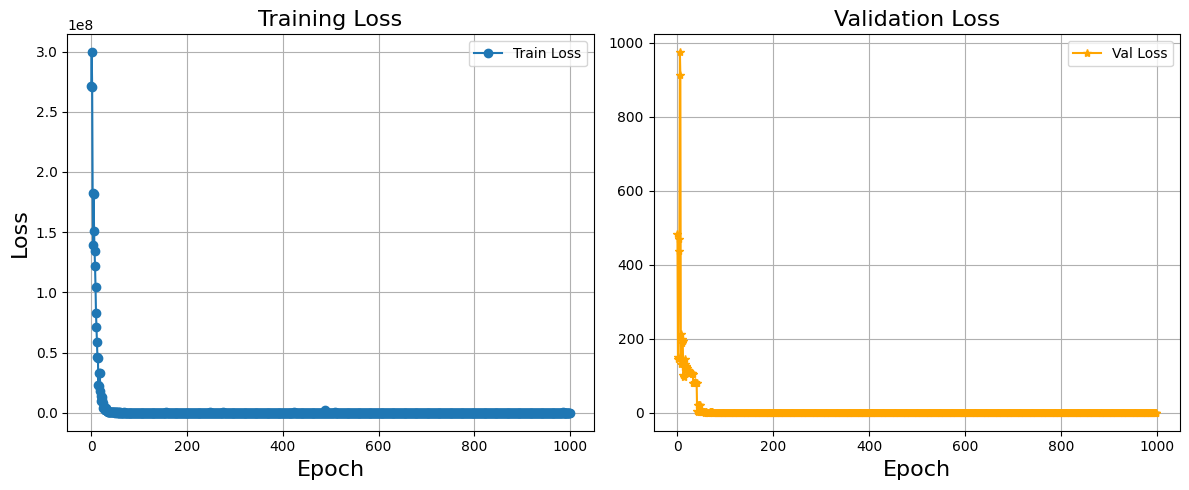

In [4]:
# 2. train and validation loss hist:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: training loss
axes[0].plot(train_loss_history, marker='o', label='Train Loss')
axes[0].set_title('Training Loss', fontsize = 16)
axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 16)
axes[0].grid(True)
axes[0].legend()

# Right: validation loss
axes[1].plot(val_loss_history, marker='*', color='orange', label='Val Loss')
axes[1].set_title('Validation Loss', fontsize = 16)
axes[1].set_xlabel('Epoch', fontsize = 16)
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.savefig(f'{results_dir}testing_validation_loss.png')

print(np.array(train_loss_history).min(), ':', np.array(train_loss_history).max())
print(np.array(val_loss_history).min(), ':', np.array(val_loss_history).max())

In [5]:
import jax.numpy as jnp
from typing import Sequence, Callable
import os
from flax.training import checkpoints
import jax
from functools import partial
from models.models_2.model_gumbel import create_train_state, ROMModel
import math


gpu_devices = jax.devices("gpu")
if gpu_devices:
    device = gpu_devices[0]
else:
    device = jax.devices("cpu")[0]


def build_library(X_hat: jnp.ndarray,
                  funcs: Sequence[Callable[[jnp.ndarray], jnp.ndarray]]) -> jnp.ndarray:
    """
    X_hat: (batch, r)          # reduced variables
    funcs: list of callables f: (batch,r)->(batch,r)
    returns: (batch, r * L)    # concatenated along feature dim
    """
    
    outs = [f(X_hat) for f in funcs]            # each (b,r)
    return jnp.concatenate(outs, axis=1)        # (b, rL)


with open("../data/u_10m_comp_vals_3.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

S_train = loaded_data['train']['data']
train_times = loaded_data['train']['time']

S_test = loaded_data['test']['data']
test_times = loaded_data['test']['time']

S_val = loaded_data['val']['data']
val_times = loaded_data['val']['time']

lat_vals = loaded_data['lat_vals']
lon_vals = loaded_data['lon_vals']

batch_size = max(S_train.shape[1] // 256, 256)

Nh_val = S_train.shape[0]
l_val = 24
r_val = 20
num_features_select = 30

steps_per_epoch = (S_train.shape[1] + batch_size - 1) // batch_size
alpha_const = math.exp(math.log(min_temp / start_temp) / (num_epochs * steps_per_epoch))

X_train = S_train[:, :-1]
Y_train = S_train[:, 1:]


U_vals = loaded_data['U_vals']
sing_vals = loaded_data['sing_vals']
Vt_vals = loaded_data['Vt_vals']

U_l = U_vals[:, :l_val]
sing_l = sing_vals[:l_val]
Vt_l = Vt_vals[:l_val, :]

X_test = S_test[:,:-1]
Y_test = S_test[:,1:]

A_operator = Y_train @ Vt_l.T @ jnp.linalg.inv(jnp.diag(sing_l)) @ U_l.T
A_tilde = U_l.T @ A_operator @ U_l

phi_mat = jnp.vstack([
    jnp.eye(r_val, dtype=jnp.float32),
    jnp.zeros((l_val - r_val, r_val), dtype=jnp.float32),
])


U_r = U_l @ phi_mat # (Nh x rval)
A_hat = phi_mat.T @ A_tilde @ phi_mat



@partial(jax.jit, static_argnums=(1,))
def apply_selected_funcs(S_hat: jnp.ndarray, lib_funcs: Sequence[Callable[[jnp.ndarray], jnp.ndarray]]) -> jnp.ndarray:
    results = [f(S_hat) for f in lib_funcs]
    return jnp.concatenate(results, axis=0)

logit_vals_hist = final_results['logit_vals_hist']

best_logits = logit_vals_hist[np.argmin(val_loss_history)]

selected_indices = jnp.argmax(best_logits, axis = -1)


model = ROMModel(
    A_tilde = A_tilde,
    A_hat = A_hat, 
    phi_mat = phi_mat,
    library_functions= library_functions,
    min_temp     = min_temp,
    start_temp   = start_temp,
    alpha_const  = alpha_const,
    r_val  = r_val,
    p_val  = num_features_select,
    U_r = U_r,
    selector_type='gumbel',
    repulsion_coefficient = repulsion_coefficient
)

rng = jax.random.PRNGKey(0)
restored_state = create_train_state(
    rng,
    model,
    batch_size= batch_size,
    r_val = r_val,
    Nh = S_train.shape[0],
    lr=initial_lr,
)

CKPT_DIR = f"{results_dir}checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR,
    target=restored_state       # will be replaced with the latest checkpoint
)

2025-07-22 14:01:25.233657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-22 14:01:25.256981: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-22 14:01:25.744453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-07-22 14:01:25.744512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-07-22 14:01:25.744517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [6]:
print(selected_indices)

[98 85 80 85 75 98 77 75 86 64 79 69 65 92 93 72 88 76 79 72 89 87 62 88
 83 89 92 77 64 61]


[Array(0.32405406, dtype=float32), Array(0.3159918, dtype=float32), Array(0.31500113, dtype=float32), Array(0.3205304, dtype=float32), Array(0.3276278, dtype=float32), Array(0.3377429, dtype=float32), Array(0.34811422, dtype=float32), Array(0.3563154, dtype=float32), Array(0.36707547, dtype=float32), Array(0.40931457, dtype=float32), Array(0.41638008, dtype=float32), Array(0.42051047, dtype=float32), Array(0.43843523, dtype=float32), Array(0.46258092, dtype=float32), Array(0.48614427, dtype=float32), Array(0.5055644, dtype=float32), Array(0.5281116, dtype=float32), Array(0.55133164, dtype=float32), Array(0.57542926, dtype=float32), Array(0.5917512, dtype=float32), Array(0.6027206, dtype=float32), Array(0.64192706, dtype=float32), Array(0.6521416, dtype=float32), Array(0.6571481, dtype=float32), Array(0.6684265, dtype=float32), Array(0.6748001, dtype=float32), Array(0.67684025, dtype=float32), Array(0.67364764, dtype=float32), Array(0.6722977, dtype=float32), Array(0.6682843, dtype=floa

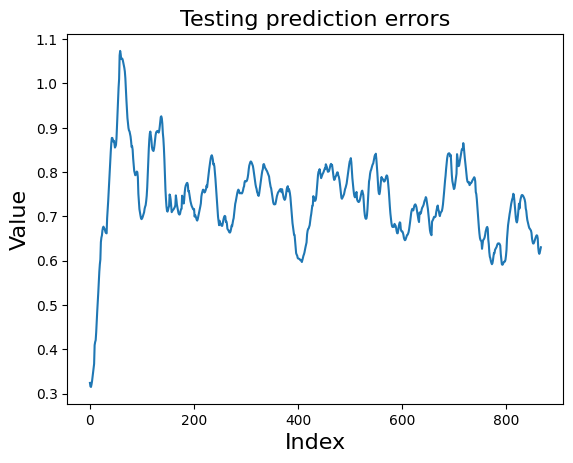

In [8]:
library_functions = [ "(_)**2", "(_)**3", "(_)**4", "jnp.sin(_)", "jnp.cos(_)" ]
library_functions = make_library_functions(library_functions)
repulsion_coefficient = 1e-1

phi_bar_t = restored_state.params['phi_bar_t']
H_hat = phi_mat.T @ A_tilde @ phi_bar_t.T 

x0 = X_test[:, 0]
x_hat0 = U_r.T @ x0

def step(xh, _):
    mod = apply_selected_funcs(xh, tuple(library_functions))
    mod_sel = jnp.take(mod, selected_indices)
    xh = A_hat @ xh + H_hat @ mod_sel
    return (xh, xh)

_, xh_seq = jax.lax.scan(step, x_hat0, None, length=Y_test.shape[1])

X_test_batch_rec = U_r @ xh_seq.T

# print(Y_test.shape, X_test_batch_rec.shape)

test_pred_errs = []
for i in range(Y_test.shape[1]):
    err_val = jnp.linalg.norm( Y_test[:,i] - X_test_batch_rec[:,i])/ jnp.linalg.norm(Y_test[:,i])
    test_pred_errs.append(err_val)

plt.plot(test_pred_errs)
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Testing prediction errors', fontsize = 16)
plt.savefig(f'{results_dir}test_pred_errs.png')
print(test_pred_errs)


In [ ]:

# H_hat = phi_mat.T @ A_tilde @ phi_bar_t.T 

# def step(xh, _):
#     mod = apply_selected_funcs(xh, library_functions)
#     mod_sel = jnp.take(mod, selected_indices)
#     xh = A_hat @ xh + H_hat @ mod_sel
#     return (xh, xh)

# _, xh_seq = jax.lax.scan(step, x_hat0, None, length=Y_val_batch.shape[1])

# X_val_batch_rec = U_r @ xh_seq.T


# H_hat = phi_mat.T @ A_tilde @ phi_bar_t.T 

# X_test = X_test_t.T
# X_hat_test = U_r.T @ X_test
# X_hat_test_t = X_hat_test.T

# Y_test  = Y_test_t.T

# X_val_mod_t = build_library(X_hat_val_t, library_functions)  # (bsize, r_val x len(lib))

# # X_mod_t_batch = build_library(X_hat_t_batch, self.library_functions)  # (bsize, r_val x len(lib))

# X_val_hat_nl_t = jnp.take(X_val_mod_t, selected_indices, axis = 1) # (bsize, p_val)

# X_val_rec_hat = A_hat @ X_hat_val + H_hat @ X_val_hat_nl_t.T  # (r,r) @ (r, k) + (r,p) @ (p, k) 

# X_val_rec = U_r @ X_val_rec_hat # (Nh, r) @ (r, k)

# reconstr_err = jnp.linalg.norm(Y_val - X_val_rec)/ jnp.linalg.norm(Y_val)

# return reconstr_err/N


# test_pred_errs = []
# for i in range(x_test.shape[0]):
#     test_pred_errs.append(np.linalg.norm(x_test[i] - S_test_pred[i])/ np.linalg.norm(x_test[i]))

# np.save(f'{results_dir}test_pred_err_vals.npy', test_pred_errs)

# plt.plot(test_pred_errs)
# plt.xlabel('Index', fontsize = 16)
# plt.ylabel('Value', fontsize = 16)
# plt.title('Relative error for predicting testing data', fontsize = 16)
# plt.savefig(f'{results_dir}test_pred_errs.png')
# print(np.array(test_pred_errs).min(), ":", np.array(test_pred_errs).max())
